In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from functools import partial
from tensorflow import keras
import sys
sys.path.append("..")
from train_models import train_wide, probe_dir
from data_prep import norm_image
from evaluate_models import plot_cm, process_labels, calc_precision_recall, calc_f1
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import time

In [2]:
X = np.load('../../data/galaxy_X.npy')
y = np.load('../../data/galaxy_y.npy')

In [3]:
X_tmp_train, X_test1, y_tmp_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=42, shuffle=True, stratify=y)
X_train1, X_val1, y_train, y_val = train_test_split(X_tmp_train, y_tmp_train, test_size=0.11, train_size=0.89, random_state=42, shuffle=True, stratify=y_tmp_train)

In [4]:
#Set seeds to be able to reproduce network
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Apply normalization to images
def normalize_images(X):
    return np.array(list(map(normalize_image, X)))
    
def normalize_image(img):
    bot = np.min(img)
    top = np.max(img)
    norm = (img - bot)/(top - bot)
    return norm

X_train = normalize_images(X_train1)
X_val = normalize_images(X_val1)
X_test = normalize_images(X_test1)

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [6]:
def reshape_predictions(pred):
    length = len(pred[0])
    new_preds = []
    for j in range(length):
        feats = []
        for i in range(4):
            feats.append(pred[i][j, 0])
        new_preds.append(feats)
    return np.array(new_preds)

In [7]:
runs = 20
total_loss = 0
total_acc = 0
elapsed = 0

# Execute a few runs of training the network
for run in range(1,runs+1):
    aux_model = keras.models.load_model(f'../../models/aux_model{run}.h5')
    X_train_pred = aux_model.predict(X_train)
    X_train_aux = reshape_predictions(X_train_pred)
    X_val_pred = aux_model.predict(X_val)
    X_val_aux = reshape_predictions(X_val_pred)
    X_test_pred = aux_model.predict(X_test)
    X_test_aux = reshape_predictions(X_test_pred)
    start = time.time()
    tmp_loss, tmp_acc = train_wide(X_train_aux, X_train, y_train, X_val_aux, X_val, y_val, X_test_aux, X_test, y_test,  run)
    keras.backend.clear_session()
    end = time.time()
    elapsed += (end - start)
    total_loss += tmp_loss
    total_acc += tmp_acc
avg_loss = total_loss/runs
avg_acc = total_acc/runs
avg_elapsed = elapsed/runs

Epoch 1/100
22/22 [==============================] - 12s 396ms/step - loss: 1.2032 - categorical_accuracy: 0.5100 - val_loss: 0.8696 - val_categorical_accuracy: 0.6092
Epoch 2/100
22/22 [==============================] - 7s 342ms/step - loss: 0.8853 - categorical_accuracy: 0.6624 - val_loss: 0.6449 - val_categorical_accuracy: 0.7471
Epoch 3/100
22/22 [==============================] - 7s 336ms/step - loss: 0.7422 - categorical_accuracy: 0.7123 - val_loss: 0.6141 - val_categorical_accuracy: 0.8046
Epoch 4/100
22/22 [==============================] - 7s 341ms/step - loss: 0.6035 - categorical_accuracy: 0.7778 - val_loss: 0.4423 - val_categorical_accuracy: 0.8506
Epoch 5/100
22/22 [==============================] - 5s 241ms/step - loss: 0.5139 - categorical_accuracy: 0.8048 - val_loss: 0.5824 - val_categorical_accuracy: 0.7701
Epoch 6/100
22/22 [==============================] - 7s 337ms/step - loss: 0.4577 - categorical_accuracy: 0.8390 - val_loss: 0.4123 - val_categorical_accuracy: 0.87

In [8]:
# Evaluate the number of epochs it took to train the networks
runs = 20
epochs_log = []
for run in range(1,runs+1):
    ea = EventAccumulator(f'../../lr_logs/wide_run{run}/train')
    ea.Reload()
    ct_loss, epochs_loss, loss = zip(*ea.Tensors('epoch_loss'))
    epochs_loss = np.asarray(epochs_loss)
    epochs_log.append(epochs_loss[-1] + 1)

epochs_log = np.array(epochs_log)
avg_epochs = np.mean(epochs_log)
min_idx = np.argmin(epochs_log) + 1
min_epochs = epochs_log[min_idx - 1]
max_idx = np.argmax(epochs_log) + 1
max_epochs = epochs_log[max_idx - 1]

In [9]:
tmp = np.array([avg_acc, avg_loss, avg_elapsed, avg_epochs, max_epochs, max_idx, min_epochs, min_idx])
probe_dir('../../results/')
np.save('../../results/wide_results.npy', tmp)
tmp = np.load('../../results/wide_results.npy')

In [10]:
print(f"Average accuracy: {tmp[0]}")
print(f"Average loss: {tmp[1]}")
print(f"Average time taken: {tmp[2]}")
print(f"Average epochs taken: {tmp[3]}")
print(f"Maximum number of epochs taken was {tmp[4]} at run {tmp[5]}")
print(f"Minimum number of epochs taken was {tmp[6]} at run {tmp[7]}")

Average accuracy: 0.8522727489471436
Average loss: 0.3338468670845032
Average time taken: 102.8077757358551
Average epochs taken: 15.0
Maximum number of epochs taken was 15.0 at run 1.0
Minimum number of epochs taken was 15.0 at run 1.0


Average bent precision: 0.7894736842105263
Average bent recall: 0.7142857142857143
Average bent F1: 0.7500000000000001
Average comp precision: 0.8461538461538461
Average comp recall: 1.0
Average comp F1: 0.9166666666666666
Average FRI precision: 1.0
Average FRI recall: 0.8888888888888888
Average FRI F1: 0.9411764705882353
Average FRII precision: 0.825
Average FRII recall: 0.868421052631579
Average FRII F1: 0.8461538461538461
Average Macro F1: 0.8634992458521871


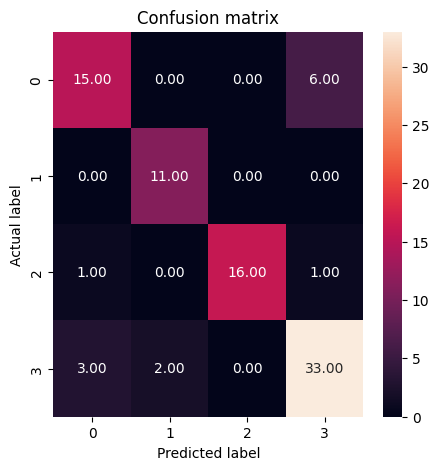

In [11]:
bent_precs, bent_recalls, bent_f1s = [], [], []
comp_precs, comp_recalls, comp_f1s = [], [], []
fri_precs, fri_recalls, fri_f1s = [], [], []
frii_precs, frii_recalls, frii_f1s = [], [], []
macro_f1s = []
average_cm = np.zeros((4, 4))
runs = 20
for run in range(1,runs+1):
    aux_model = keras.models.load_model(f'../../models/aux_model{run}.h5')
    X_test_pred = aux_model.predict(X_test)
    X_test_aux = reshape_predictions(X_test_pred) 
    best_model = keras.models.load_model(f"../../models/wide_model{run}.h5")
    test_pred = best_model.predict((X_test_aux, X_test))
    new_test_true, new_test_pred = process_labels(y_test, test_pred)
    cm = confusion_matrix(new_test_true, new_test_pred)
    average_cm += cm
    bent_prec, bent_recall = calc_precision_recall(cm, 0)
    bent_precs.append(bent_prec)
    bent_recalls.append(bent_recall)
    bent_f1s.append(calc_f1(bent_prec, bent_recall))
    comp_prec, comp_recall = calc_precision_recall(cm, 1)
    comp_precs.append(comp_prec)
    comp_recalls.append(comp_recall)
    comp_f1s.append(calc_f1(comp_prec, comp_recall))
    fri_prec, fri_recall = calc_precision_recall(cm, 2)
    fri_precs.append(fri_prec)
    fri_recalls.append(fri_recall)
    fri_f1s.append(calc_f1(fri_prec, fri_recall))
    frii_prec, frii_recall = calc_precision_recall(cm, 3)
    frii_precs.append(frii_prec)
    frii_recalls.append(frii_recall)
    frii_f1s.append(calc_f1(frii_prec, frii_recall))
    macro_f1s.append((bent_f1s[-1] + comp_f1s[-1] + fri_f1s[-1] + frii_f1s[-1])/4)

average_cm = average_cm/runs
print(f'Average bent precision: {np.mean(bent_precs)}')
print(f'Average bent recall: {np.mean(bent_recalls)}')
print(f'Average bent F1: {np.mean(bent_f1s)}')
print(f'Average comp precision: {np.mean(comp_precs)}')
print(f'Average comp recall: {np.mean(comp_recalls)}')
print(f'Average comp F1: {np.mean(comp_f1s)}')
print(f'Average FRI precision: {np.mean(fri_precs)}')
print(f'Average FRI recall: {np.mean(fri_recalls)}')
print(f'Average FRI F1: {np.mean(fri_f1s)}')
print(f'Average FRII precision: {np.mean(frii_precs)}')
print(f'Average FRII recall: {np.mean(frii_recalls)}')
print(f'Average FRII F1: {np.mean(frii_f1s)}')
print(f'Average Macro F1: {np.mean(macro_f1s)}')
plot_cm(average_cm)